In [ ]:
import torch
from torch import nn, Tensor
from datetime import datetime
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util
from sentence_transformers import SentenceTransformer, LoggingHandler, models, evaluation, losses
from sentence_transformers.datasets import ParallelSentencesDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
student_model_name = 'xlm-roberta-base'

In [ ]:
# Student Model
word_embedding_model = models.Transformer(student_model_name, max_seq_length=128)
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
student_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Add [EM] token to the vocabulary
word_embedding_model = student_model._first_module()
tokens = ["[EM]"]
word_embedding_model.tokenizer.add_tokens(tokens, special_tokens=True)
word_embedding_model.auto_model.resize_token_embeddings(len(word_embedding_model.tokenizer))

Embedding(250003, 768)

## Visualization with neg samples

In [ ]:
model_saved = SentenceTransformer("output/test-xlm-roberta-base-200epochs-my_split=False")

In [ ]:
Evaluate_performance(model_saved, generate_negative_samples(test))

(266, 3)


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


0.9699248120300752

In [ ]:
new_data = pd.read_csv("./Data/new_ELCo.csv")
new_data.head()

,English,Emoji,emoji_list,label
0,big business,[EM]necktie[EM]chart increasing[EM],"[':necktie:', ':chart_increasing:']",1
1,big business,[EM]hourglass not done[EM]beach with umbrella[...,"[':hourglass_not_done:', ':beach_with_umbrella...",0
2,big business,[EM]office building[EM]money-mouth face[EM]mon...,"[':office_building:', ':money-mouth_face:', ':...",1
3,big business,[EM]cross mark[EM]light bulb[EM]candle[EM],"[':cross_mark:', ':light_bulb:', ':candle:']",0
4,big business,[EM]man technologist[EM]handshake[EM],"[':man_technologist:', ':handshake:']",1


In [ ]:
def cal_similarity(model, row):
    return util.cos_sim(model.encode(row['English']), model.encode(row['Emoji'])).numpy()[0][0]

In [ ]:
new_data['score'] = new_data.apply(lambda x: cal_similarity(model_saved,x), axis=1)
new_data['score_before'] = new_data.apply(lambda x: cal_similarity(student_model,x), axis=1)

In [ ]:
new_data.head(10)

,English,Emoji,emoji_list,label,score,query,score_before
0,big business,[EM]necktie[EM]chart increasing[EM],"[':necktie:', ':chart_increasing:']",pos sample,0.063323,1,0.985820
1,big business,[EM]hourglass not done[EM]beach with umbrella[...,"[':hourglass_not_done:', ':beach_with_umbrella...",neg sample,0.031602,1,0.977732
2,big business,[EM]office building[EM]money-mouth face[EM]mon...,"[':office_building:', ':money-mouth_face:', ':...",pos sample,0.976350,2,0.980846
3,big business,[EM]cross mark[EM]light bulb[EM]candle[EM],"[':cross_mark:', ':light_bulb:', ':candle:']",neg sample,-0.014587,2,0.975034
4,big business,[EM]man technologist[EM]handshake[EM],"[':man_technologist:', ':handshake:']",pos sample,0.305160,3,0.984823
5,big business,[EM]disappointed face[EM]money bag[EM],"[':disappointed_face:', ':money_bag:']",neg sample,0.242096,3,0.987591
6,big business,[EM]office building[EM]people holding hands[EM...,"[':office_building:', ':people_holding_hands:'...",pos sample,0.969918,4,0.972648
7,big business,[EM]window[EM]light bulb[EM],"[':window:', ':light_bulb:']",neg sample,0.163820,4,0.985540
8,big business,[EM]woman technologist[EM]money-mouth face[EM],"[':woman_technologist:', ':money-mouth_face:']",pos sample,0.965750,5,0.985143
9,big business,[EM]face with steam from nose[EM]speaking head...,"[':face_with_steam_from_nose:', ':speaking_hea...",neg sample,-0.024826,5,0.982940


In [ ]:
new_data.loc[new_data['label'] == 1,'label'] = 'pos sample'
new_data.loc[new_data['label'] == 0,'label'] = 'neg sample'

In [ ]:
new_data['query'] = [i for i in range(1, int(len(new_data)/2) + 1) for _ in range(2)]

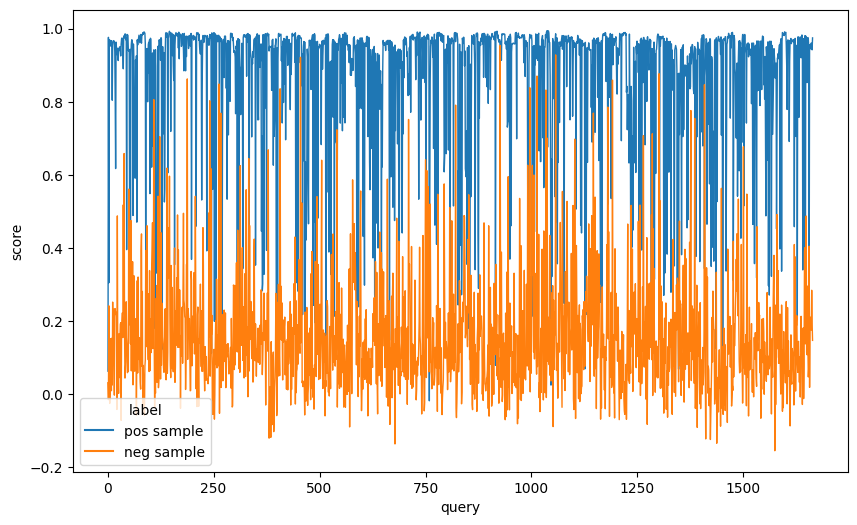

In [ ]:
# palette = sns.color_palette("mako_r", 6)
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=new_data, x = 'query', y = 'score', hue='label', ax=ax, linewidth = 1)
plt.show()

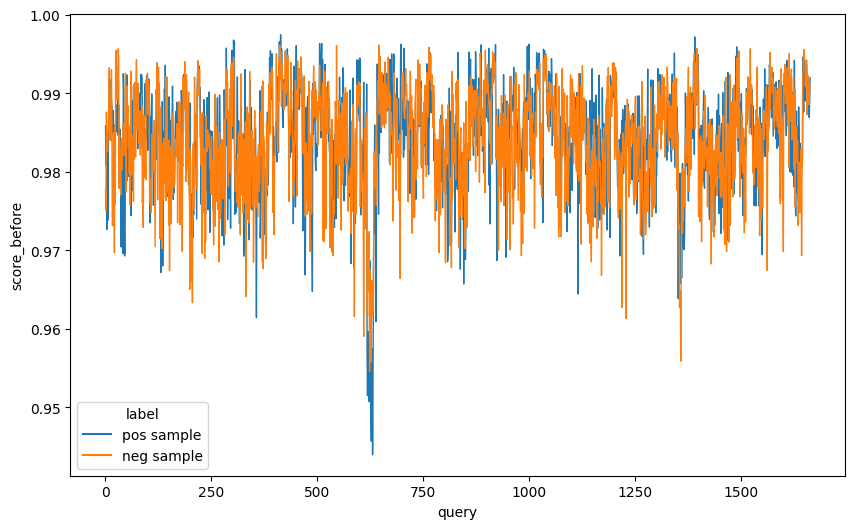

In [ ]:
# palette = sns.color_palette("mako_r", 6)
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=new_data, x = 'query', y = 'score_before', hue='label', ax=ax, linewidth = 1)
plt.show()